In [68]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['font.size'] = 25

# start from here
bankFile = "balanceSheetAnalysis/banksData_2022.csv"
params = {"banksFile" : bankFile, # csv file used to initialize the bank agents
                 "leverageRatio": 10.0, # leverage ratio upper bound for all banks
                 "depositReserve": 0.2, # capital reserve as a ratio of deposit
                 "num_borrowing": 5, # number of borrowing request per bank per step
                 "sizeOfBorrowing": 1.0, # size of borrowing as a ratio of equity capital
                 "concentrationParameter": None, #np.load("concentrationParams.npy"), # concentration parameter for the dirichlet distribution
                 "num_banks": 100, # number of banks in the system 
                 "alpha" : 0.5,    # portfolio recovery rate          
                 "beta" : 0.9,     # interbank loan recovery rate
                 "fedRate" : 0.04, # interest rate on borrowing   
                 "portfolioReturnRate" : 0.10, 
                 "returnVolatiliy" : 0.18,
                 "returnCorrelation" : 0.9,
                 "shockSize" : 10,       # size of the shock
                 "shockDuration":[-1,-1] # time of the shock, [-1,-1] sugguests no shock
                 } 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### model without the exogeous shock

In [69]:
numberOfRun = 960
simulationSteps = 500
rCollection = multiRun(numberOfRun, params)

480
432
384
336
288
240
192
144
96
48


In [70]:
density = np.zeros((numberOfRun, simulationSteps))
for i,r in enumerate(rCollection):
    if i == 0:
        agentData, modelData = r[0].copy(), r[1].copy()
        IndegreeCollection = np.array([(modelData["Liability Matrix"][j]>0).sum(axis=0) for j in range(simulationSteps)], dtype=np.float64)
        OutdegreeCollection = np.array([ (modelData["Liability Matrix"][j]>0).sum(axis=1) for j in range(simulationSteps)], dtype=np.float64)
        density[i] = np.array([(modelData["Liability Matrix"][j]>0).sum()/50/49 for j in range(simulationSteps)], dtype=np.float64)

    else:
        a = r[0].copy()
        m = r[1].copy()
        agentData += a
        modelData += m
        IndegreeCollection += np.array([(m["Liability Matrix"][j]>0).sum(axis=0) for j in range(simulationSteps)], dtype=np.float64)
        OutdegreeCollection += np.array([ (m["Liability Matrix"][j]>0).sum(axis=1) for j in range(simulationSteps)], dtype=np.float64)
        density[i] = np.array([(m["Liability Matrix"][j]>0).sum()/50/49 for j in range(simulationSteps)], dtype=np.float64)
        
agentData /= len(rCollection)
modelData /= len(rCollection)
IndegreeCollection /= len(rCollection)
OutdegreeCollection /= len(rCollection)

In [71]:
a = pd.read_csv(bankFile).head(100).assets

In [72]:
names = agentData.xs(0, level="Step")["PortfolioValue"].describe().index.values
data = []
for t in [0, 99,199,299,399,499]:
    data.append(agentData.xs(t, level="Step")["PortfolioValue"].describe().values.round(2))
data.append(pd.DataFrame(a).describe().values.flatten().round(2))
dd = pd.DataFrame(data, columns=names)
dd.rename(columns={"count":"Step"}, inplace=True)
dd["Step"] = [0, 100,200,300,400,500, "empirical"]
dd

,Step,mean,std,min,25%,50%,75%,max
0,0,1.925087e+08,4.845741e+08,19156553.00,28681324.50,4.693035e+07,1.519415e+08,3.476711e+09
1,100,1.956808e+08,4.383503e+08,19773838.45,38309967.74,6.291146e+07,1.627545e+08,3.112153e+09
2,200,2.024004e+08,4.144272e+08,26982672.92,48245897.32,7.697236e+07,1.805442e+08,2.956620e+09
3,300,2.031919e+08,3.727852e+08,26545654.29,49851167.04,8.039563e+07,2.034744e+08,2.371600e+09
4,400,2.075691e+08,3.316621e+08,30978399.61,55891924.16,9.576783e+07,2.229009e+08,1.869027e+09
5,500,2.141091e+08,3.104423e+08,37575810.54,63692355.28,1.037654e+08,2.363085e+08,1.582003e+09
6,empirical,1.925087e+08,4.845741e+08,19156553.00,28681324.50,4.693035e+07,1.519415e+08,3.476711e+09


In [73]:
names = agentData.xs(0, level="Step")["Leverage"].describe().index.values
data = []
for t in [0, 99,199,299,399,499]:
    data.append(agentData.xs(t, level="Step")["Leverage"].describe().values)
dd = pd.DataFrame(data, columns=names)
dd.rename(columns={"count":"Step"}, inplace=True)
dd["Step"] = [0, 100,200,300,400,500]
dd

,Step,mean,std,min,25%,50%,75%,max
0,0,3.076881,0.426532,1.896099,2.846676,3.116365,3.314369,4.199422
1,100,6.708357,1.265387,2.830572,6.037778,6.955775,7.567658,9.293783
2,200,7.045792,1.131776,2.881567,6.585514,7.310275,7.775456,8.827392
3,300,7.399792,1.030904,3.049213,6.923677,7.613016,8.083910,8.995568
4,400,7.534595,0.905781,3.237824,7.141165,7.663056,8.171904,8.858916
5,500,7.464733,0.820381,3.345800,7.075516,7.602527,8.043946,8.604189


In [74]:
pd.read_csv("balanceSheetAnalysis/banksData_2022.csv")["leverage"].describe()

count    4195.000000
mean       10.564758
std         3.254038
min         1.000215
25%         8.741442
50%        10.594295
75%        12.409350
max        21.633853
Name: leverage, dtype: float64

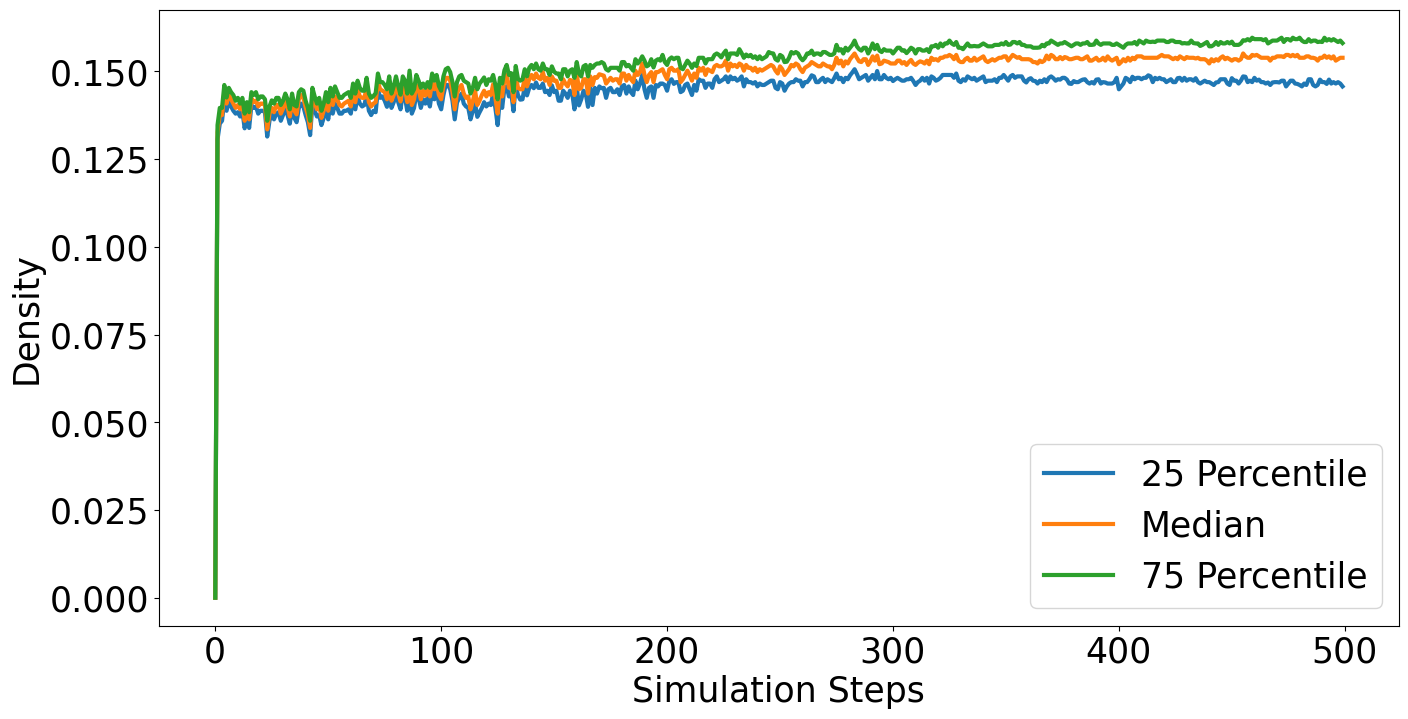

In [75]:
# Plotting
percentiles = np.percentile(density, [25, 50, 75], axis=0)
labels = ["25 Percentile", "Median", "75 Percentile"]

for i in range(percentiles.shape[0]):
    plt.plot(percentiles[i, :], linewidth =3, label=labels[i])
plt.xlabel("Simulation Steps")
plt.ylabel("Density")
plt.legend()
plt.show()

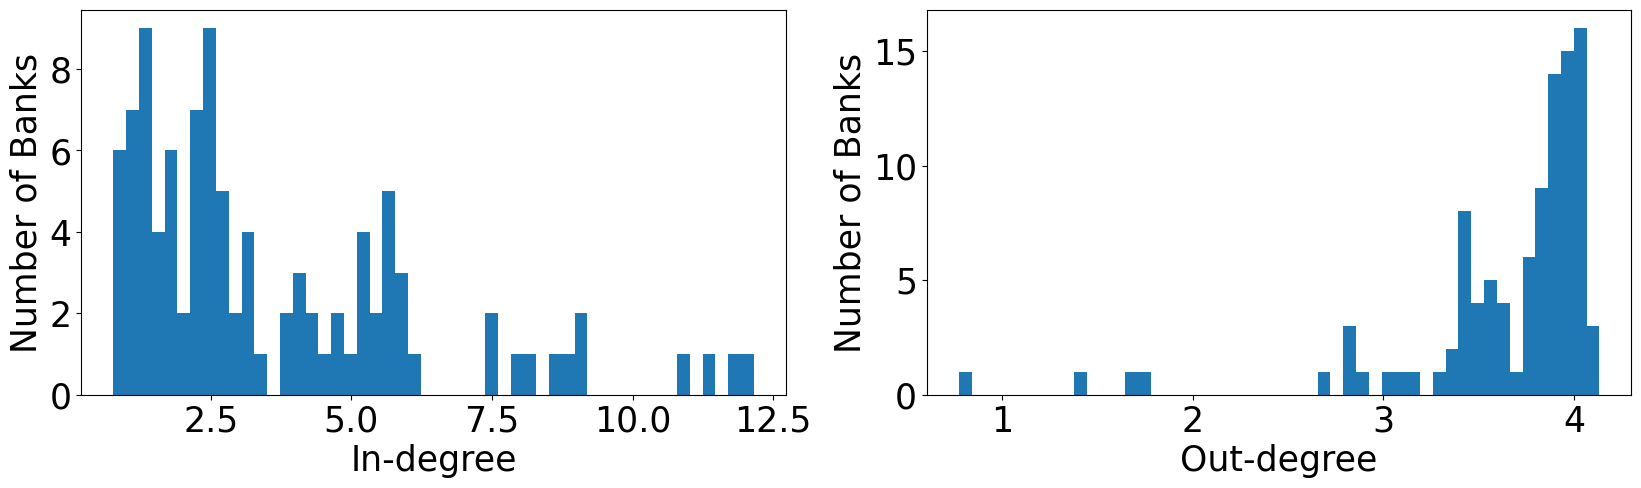

In [76]:
def plot_degree_distribution(t):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.hist(IndegreeCollection[t], bins=50)
    ax1.set_xlabel("In-degree")
    ax1.set_ylabel("Number of Banks")

    ax2.hist(OutdegreeCollection[t], bins=50)
    ax2.set_xlabel("Out-degree")
    ax2.set_ylabel("Number of Banks")
    plt.show()

plot_degree_distribution(simulationSteps-1)

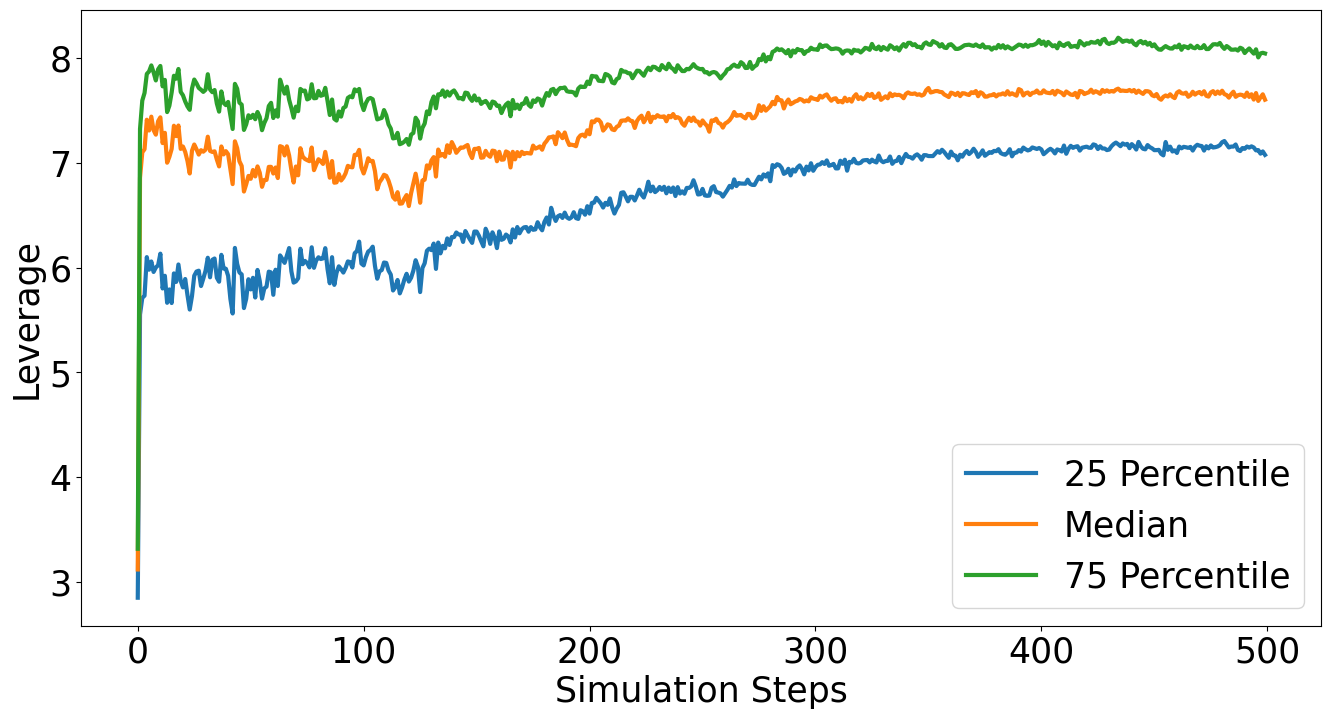

In [77]:
leverageCollection = [agentData.xs(i, level="Step")["Leverage"].values for i in range(simulationSteps)]
leverageCollection = np.array(leverageCollection)

# Plotting
percentiles = np.percentile(leverageCollection, [25, 50, 75], axis=1)
labels = ["25 Percentile", "Median", "75 Percentile"]

for i in range(percentiles.shape[0]):
    plt.plot(percentiles[i, :], linewidth =3, label=labels[i])
plt.xlabel("Simulation Steps")
plt.ylabel("Leverage")
plt.legend()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

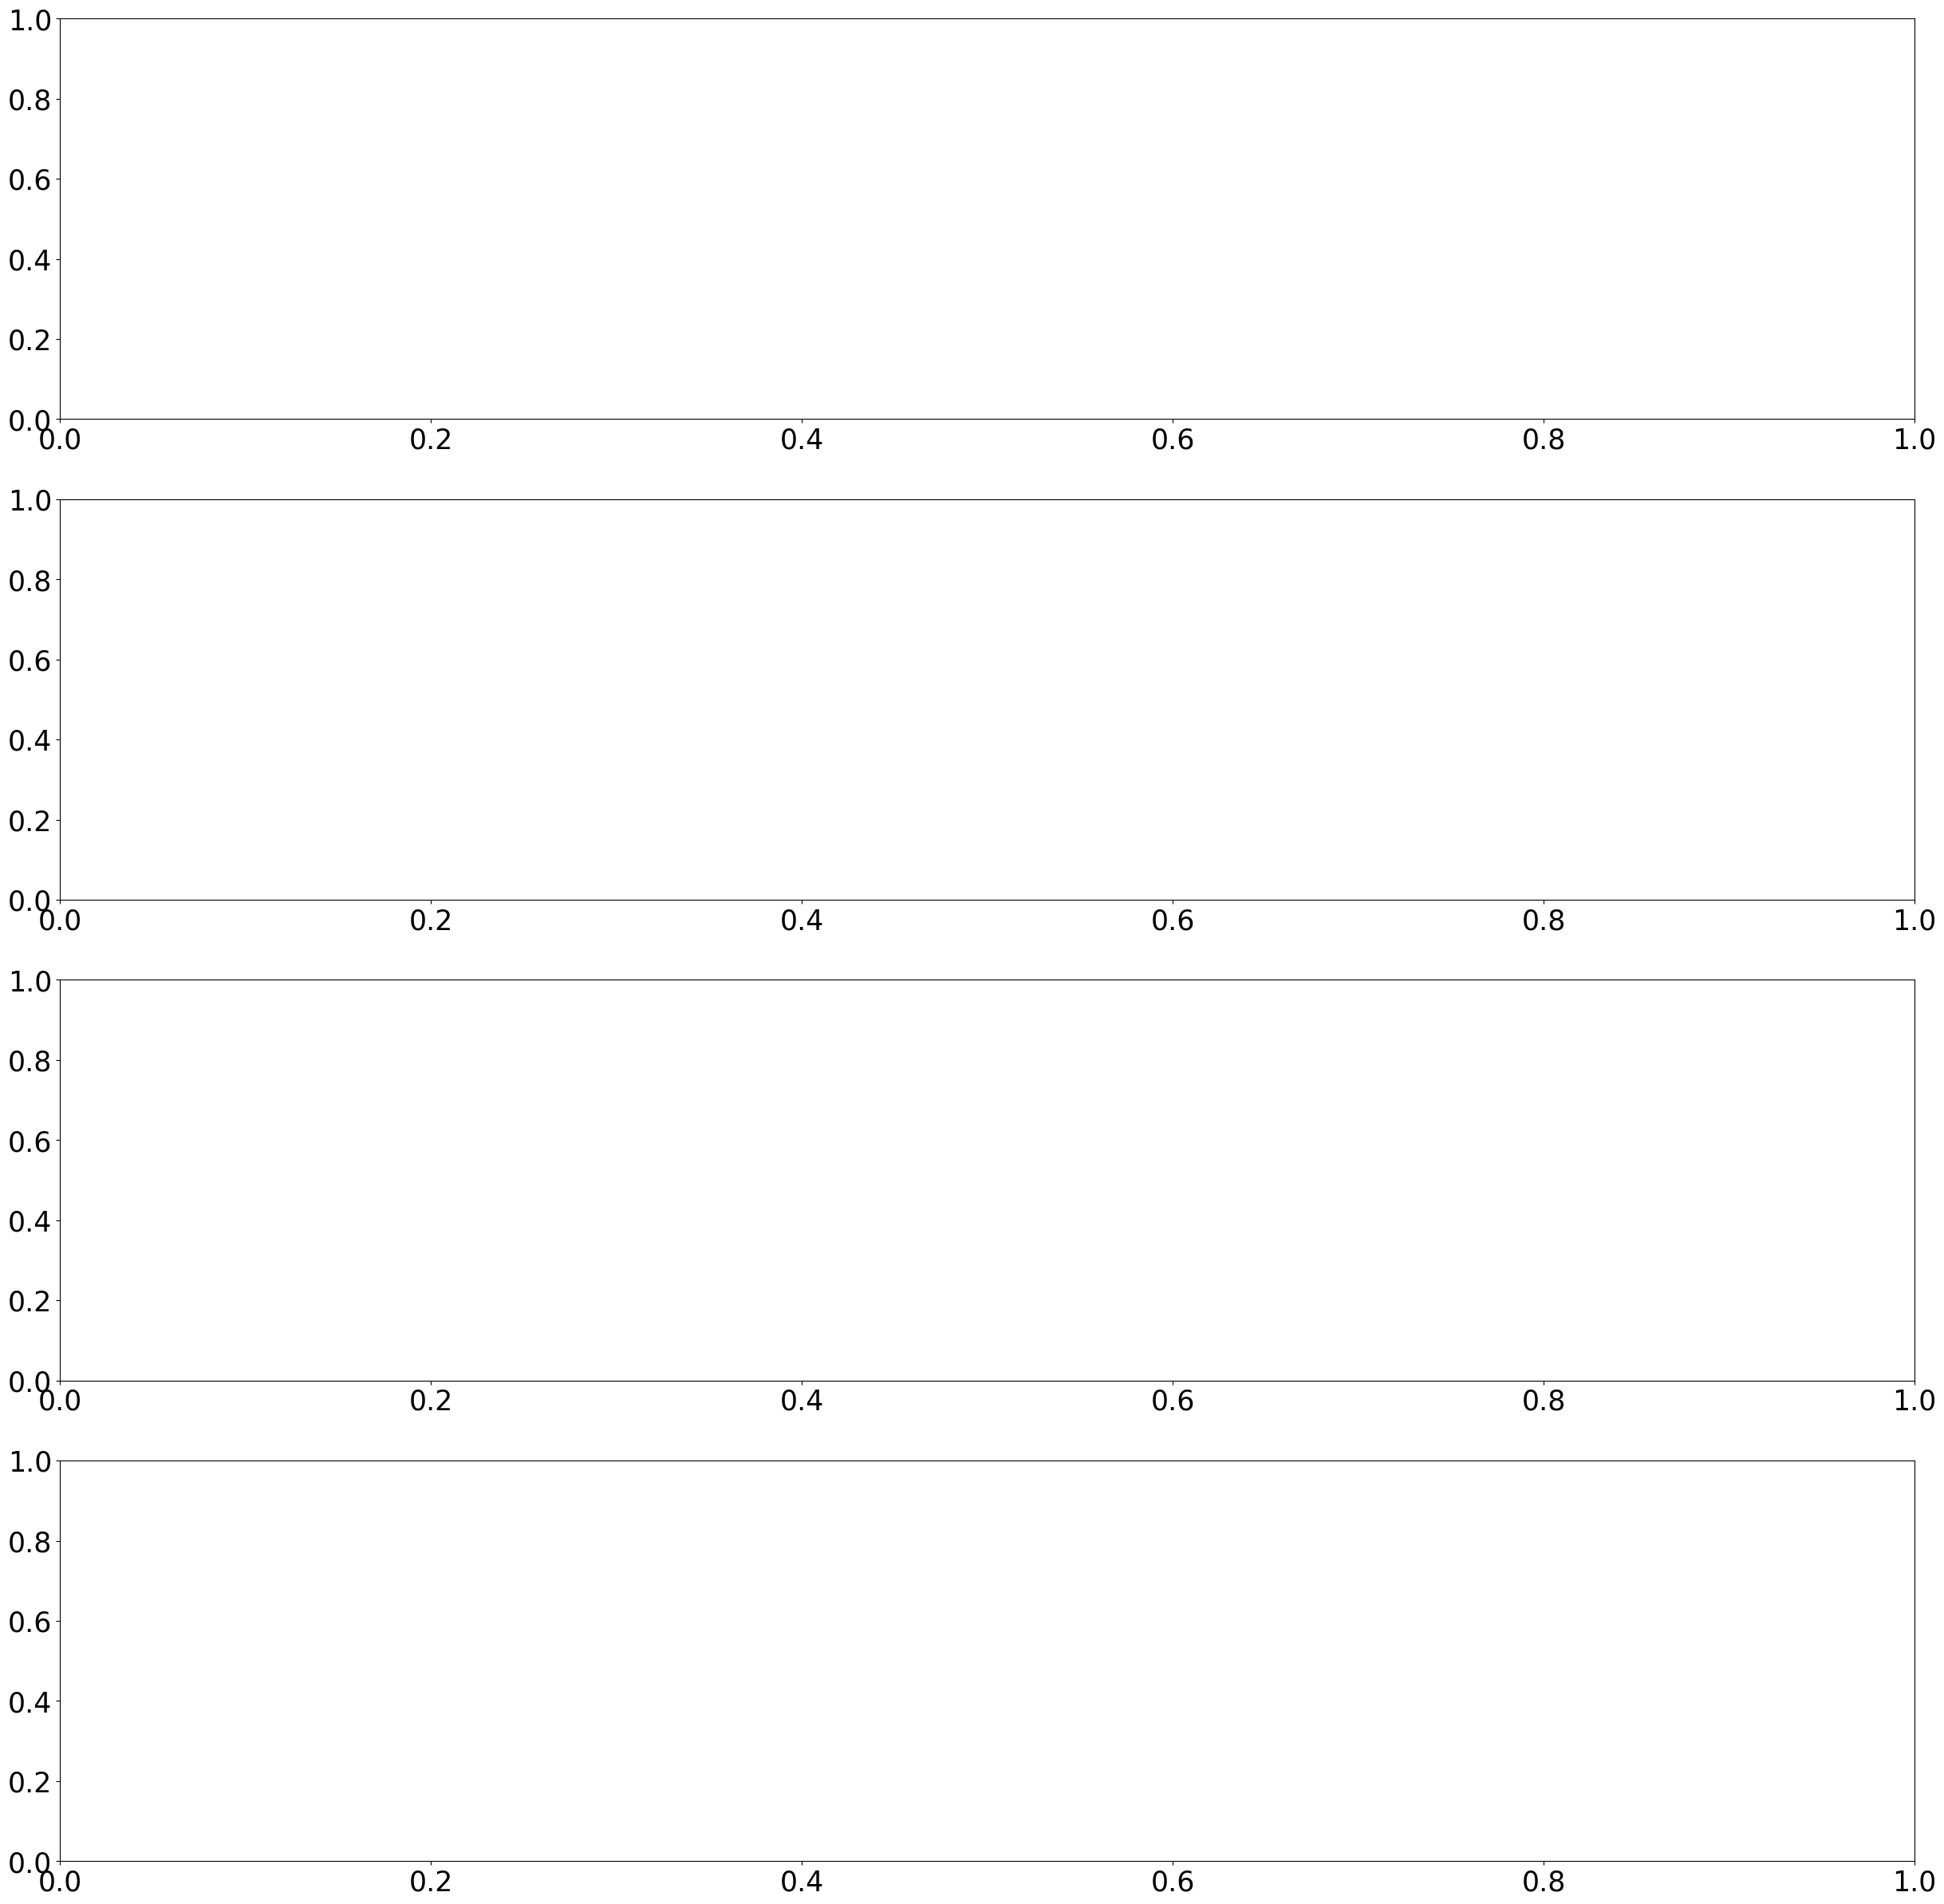

In [78]:
# bar chart of portfolio value
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_size_inches(30, 30)
ax1.bar(range(50), modelData["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated Belief")
ax2.bar(range(50), modelData["Liability Matrix"][simulationSteps].sum(axis = 0))
ax2.set_title("Lending Amount")
ax3.bar(range(50), agentData.xs(0, level="Step")["Equity"])
ax3.set_title("Equity value at the Beginning of the Simulation")
ax4.bar(range(50), agentData.xs(500, level="Step")["Equity"])
ax4.set_title("Equity value at the End of the Simulation")
ax4.set_xlabel("Bank ID")
plt.show()